In [3]:
import numpy as np

In [4]:
# Action dictionaries: each action represents a movement, and each has its own id
action_dict = {
    0: np.array([0,1]), #R
    1: np.array([0,-1]), #L
    2: np.array([-1,0]), #U
    3: np.array([1,0]), #D
}

action_dict_desc = {
    0: '→', #R
    1: '←', #L
    2: '↑', #U
    3: '↓', #D
}

In [5]:
# Policy visualization: Puts arrows correpsonding to actions given by policy pi
def describe_policy(pi):
    dpi = [[' ' for _ in range(pi.shape[1])] for _ in range(pi.shape[0])]
    for i in range(pi.shape[0]):
        for j in range(pi.shape[1]):
            dpi[i][j] = action_dict_desc[pi[i,j]]
            
    return np.array(dpi)

### Environment specification

<img src="img/env_agent.png" alt="Envronment and agent specification." width="400"/>

In [6]:
# Grid dimensions
H, W = 5, 5

# Gamma: Between 0 and 1.
#   0 - myopic agent
#   1 - farsighted agent
gamma = 0.9

# Special states
A = np.array((0, 1))
A_prime = np.array((4, 1))

B = np.array((0, 3))
B_prime = np.array((2, 3))

In [7]:
# Reward: Given a position and an action, return the new position and reward
def reward(pos, action):
    new_pos = pos+action
    
    if new_pos[0] < 0 or new_pos[0] >= H or new_pos[1] < 0 or new_pos[1] >= W:
        return pos, -1
    if np.all(pos == A):
        return A_prime, 10
    if np.all(pos==B):
        return B_prime, 5
    if np.all(pos==B_prime):
        return pos, 0
    if np.all(pos==A_prime):
        return pos, 0
    
    return new_pos, 0

### Value iteration

In [8]:
# Value iteration: Performs updates on state values until optimal values v_star are obtained
def value_iteration(V, pi, gamma):
    theta = 0.01
    while(True):
        delta = 0
        for i in range(V.shape[0]):
            for j in range(V.shape[1]):
                s = np.array([i,j])
                
                old_v = V[*s]
                action_vals = []
                for action_id in action_dict:
                    action = action_dict[action_id]
                    s_prime, r = reward(s, action)
                    
                    action_vals.append(r + gamma*V[*s_prime])
                    
                V[*s] = max(action_vals)
                delta = max(delta, abs(old_v - V[*s]))
                
        if delta < theta:
            return V

In [9]:
# Given a value function, for each state returns the action that maximizes the expected return
def greedy_policy(V, gamma):
    pi = np.zeros_like(V)
    
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            s = np.array([i,j])
            
            action_vals = np.zeros(len(action_dict))
            for action_id in action_dict:
                action = action_dict[action_id]
                s_prime, r = reward(s, action)
                
                action_vals[action_id] = r + gamma*V[*s_prime]
                
            pi[*s] = np.argmax(action_vals)
            
    return pi

In [10]:
V = np.zeros((H,W))
pi = np.random.randint(0, 4, (H,W))
gamma = 0.9

V_star = value_iteration(V, pi, gamma)
pi_star = greedy_policy(V_star, gamma)

pi_star_desc = describe_policy(pi_star)

print(pi_star_desc)

[['→' '→' '←' '→' '↓']
 ['→' '↑' '←' '←' '←']
 ['→' '↑' '←' '→' '↑']
 ['→' '↑' '←' '←' '←']
 ['↑' '→' '↑' '←' '←']]


### Policy iteration

In [11]:
# Policy evaluation: Given an initial value function and a policy, iterate the values until they converge
# to the values corresponding to the policy
def policy_evaluation(V, pi, gamma):
    delta_max=0.01
    while(True):
        delta=0
        for i in range(V.shape[0]):
            for j in range(V.shape[1]):
                val = V[i,j]
                state = np.array([i,j])
                action = action_dict[pi[i,j]]
                new_state, r = reward(state, action)
                V[i,j] = r + gamma*V[new_state[0], new_state[1]]
                
                delta = max(delta, np.abs(val - V[i,j]))

        if delta < delta_max:
            break
    
    return V 


In [12]:
# Given a policy pi and its value function V, imporve the policy by taking the greedy action wrt V
def policy_improvement(pi, V, gamma):
    new_pi = pi.copy()
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            s = np.array([i,j])
            a = pi[s[0],s[1]]
            
            max_val = -float('inf')
            for action_id in [0,1,2,3]:
                action = action_dict[action_id]
                new_pos, r = reward(s, action)
                if r + gamma*V[new_pos[0],new_pos[1]] > max_val:
                    max_val = r + gamma*V[new_pos[0],new_pos[1]]
                    new_pi[i,j] = action_id
                    
    return new_pi

In [13]:
# Policy iteration: Combines the policy evaluation and policy imporvement steps, and iterates them until
# the optimal policy is found
def policy_iteration(pi, V, gamma):
    while True:
        V = policy_evaluation(V, pi, gamma)
        new_pi = policy_improvement(pi, V, gamma)
        
        if np.all(new_pi == pi):
            break
        else:
            pi = new_pi
            
    return pi

In [25]:
pi_star = policy_iteration(pi, V, gamma)
pi_star_desc = describe_policy(pi_star)

print(pi_star_desc)

[['→' '→' '←' '→' '←']
 ['→' '↑' '←' '↑' '←']
 ['→' '↑' '←' '→' '↑']
 ['→' '↑' '←' '←' '↑']
 ['↑' '→' '↑' '←' '↑']]


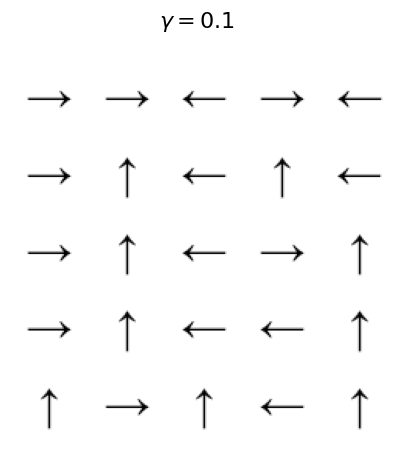

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Images
img_l = mpimg.imread('img/left.png')
img_r = mpimg.imread('img/right.png')
img_u = mpimg.imread('img/up.png')
img_d = mpimg.imread('img/down.png')

action_img = {
    0: img_r, #R
    1: img_l, #L
    2: img_u, #U
    3: img_d, #D
}

# Function to display a grid of images
def display_image_grid(policy, title, savename, image_size=(5, 5)):
    fig, axs = plt.subplots(policy.shape[0], policy.shape[1], figsize=(image_size[0], image_size[1]))
    fig.suptitle(title, fontsize=16)

    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            axs[i, j].imshow(action_img[policy[i,j]], cmap='gray')
            axs[i, j].axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.savefig(savename)


# Display the grid of images
display_image_grid(pi_star, title=r'$\gamma = 0.1$', savename='img/gamma1e-1.png')